## Read encoded track data and decode it
- Disc read data will invert on every read pulse (0->1, 1->0)
- This data represents how long the same bit value continued (bit interval, 000 -> 3, 11111 -> 5)
- The bit interval is encoded with `ord(' ')+bit_interval`. 
```sh
FDD output    :  111101110111110111011101
Captured data :  000011110000001111000011
This data     :     4   4     6   4   4 2
```

In [1]:
test = True

In [43]:
#track_data = 'FB30-0-10.txt'
#track_data = 'track2e-4m-a.txt'
#track_data = 'trk-00-0.txt'
track_data = 'putty/t1.txt'
track_data = 'putty/Protect_Killer.log'

with open(track_data, 'r') as f:
    for line in f:
        line = line.rstrip('\n')
        if '**TRACK_READ' in line:
            str = ''
        elif '**TRACK_END' in line:
            break
        else:
            str += line

interval_buf = [ ord(c)-ord(' ') for c in str ]

if test:
    print(str)

!'00888710888700888800888701878800888710888700888800888700978800888710888700888800888701879700888710888700978800888701878800888701878800888701878800888710878800888710888700978800888701888700800000000/1/000000000000000000000/1/00000000000000000000000/0000000000000000000000000/00000000009?9?80@8@71@8@700000008000000000000000871/0187000080008000800@?1888700888800888710879700888710879700888710879700888710888700888800888701878800888710888701888700888800888710888701888700978800888800888710888710700000000000000000000000000000000000000/000000000000000000000000000/1/0000000000000000000/0000018?9?80@8@71@8?800000@0@87008888008887017888008887018878008888008887018878017978008888008888008888008888008888008888/18887017978008888008887108887008888008888008887008978008888008887018878008888008888008888008887017000000000000000000000/00000000000000000000000/000000000000000/00000000000000000000000/0000000018@8@71?9?80@8@80000000800000000000000088000880000080088@888009?@8800888800888800888800888710888701888

## Display histogram of bit interval
In case the reading clock is 4MHz, 1 represents 0.25us

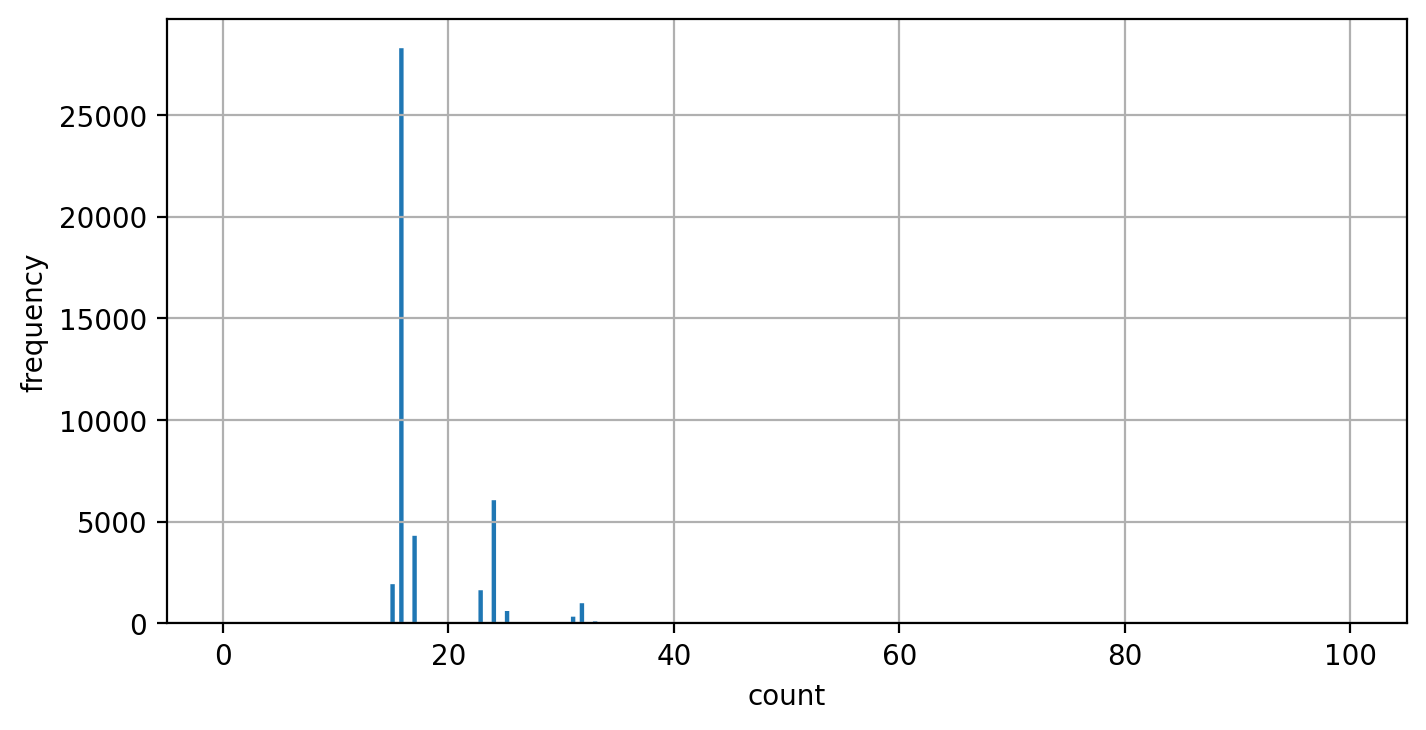

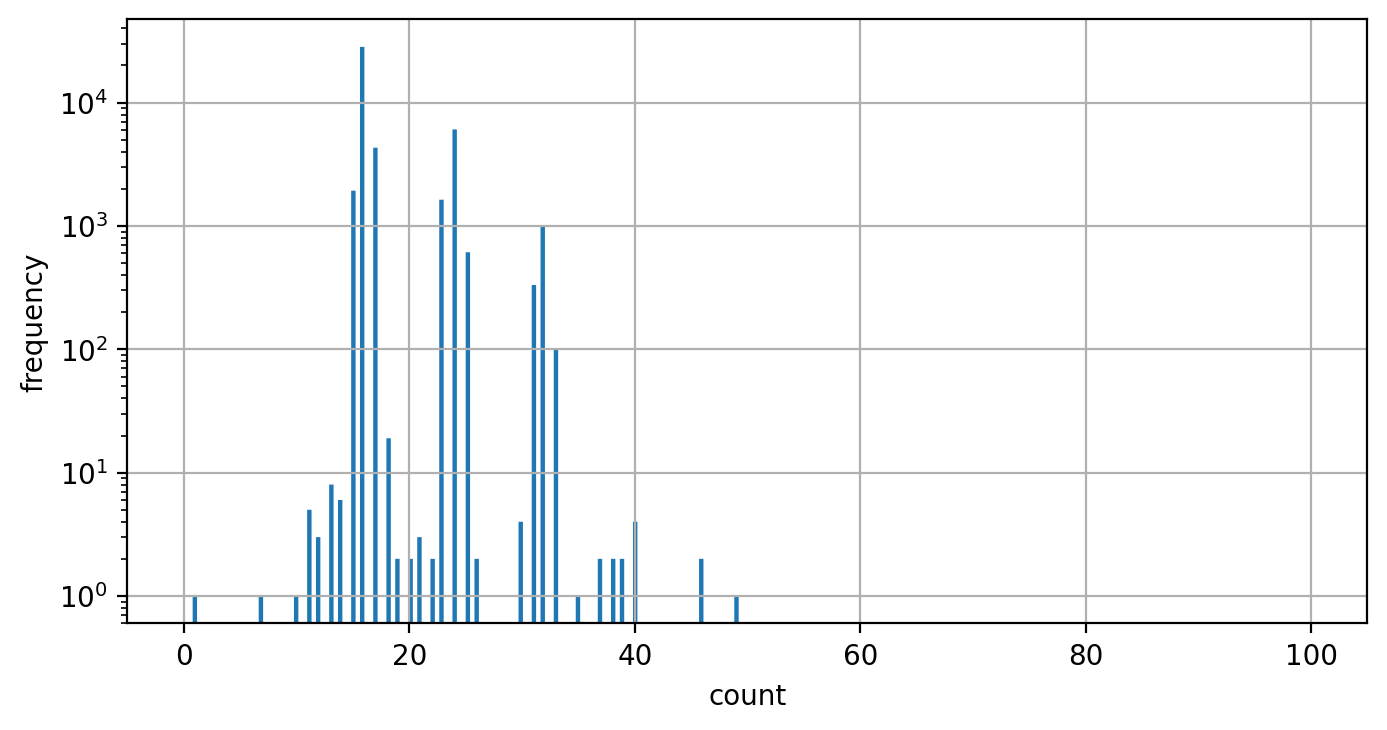

In [44]:
def generate_histogram(data):
    histo = [ 0 ] * 256
    for l in data:
        if l>=len(histo):
            l = len(histo) - 1
        histo[l]+=1
    return histo

if False:
    histo = generate_histogram(interval_buf)
    for i,v in enumerate(histo):
        print(i, v)

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4), dpi=200)
plt.xlabel('count')
plt.ylabel('frequency')
#plt.xlim(0,80)
plt.grid(True)
plt.hist(interval_buf, bins=256, range=(0,100), histtype='stepfilled', orientation='vertical', log=False)
plt.show()
plt.figure(figsize=(8,4), dpi=200)
plt.xlabel('count')
plt.ylabel('frequency')
#plt.xlim(0,80)
plt.grid(True)
plt.hist(interval_buf, bins=256, range=(0,100), histtype='stepfilled', orientation='vertical', log=True)
plt.show()

## CRC calculation routine
CRC polynomial = CCITT-16  G(X) = 1+X^5+X^12+X^16 == 1 001 000 0010 001 == 0x11021  
FDC calculates CRC from the top of the address marks (0xA1) to CRC values.  
When FDC generates CRC, the CRC field (2 bytes) are set to 0x00,0x00 and the initial CRC value is 0x84Cf.  
However, the top of address marks can't be read correctly when reading the data from the disc. I decided to skip 1st x3 0xA1 values and start CRC caluculation from (F8/FB/FC/FE) with initial value of 0xe59a.

If the data are read correctly, the return value will be 0x0000.
```python
data=[0xfe, 0x01, 0x01, 0x03, 0x01, 0xdd, 0xea]
crc_value = crc.data(data[:])  # crc_value must be 0
```

In [45]:
# G(X) = 1+X~5+X~12+X~16

# 00*14*02*A1*A1 FE 01 01 03 01 DD EA
class CCITT_CRC:
    def __init__(self):
        self.polynomial = 0x1102100    # 0001 0001 0000 0010 0001 [0000 0000]
        self.reset()

    def reset(self):
        self.crcval = 0xe59a00         # In case the 1st x3 A1s are omitted ( F8/FB/FC/FE )

    def reset2(self):
        self.crcval = 0x84cf00        # In case AM = A1 A1 A1 + F8/FB/FC/FE

    def get(self):
        return (self.crcval>>8) & 0xffff

    def data(self, buf):
        for byte in buf:
            self.crcval  |= byte
            for i in range(8):
                self.crcval <<= 1
                if self.crcval & 0x1000000 != 0:
                    self.crcval  ^= self.polynomial


if test:
    # test
    crc = CCITT_CRC()

    # FE 01 01 03 01 DD EA
    crc.reset()
    data=[0xfe, 0x01, 0x01, 0x03, 0x01, 0xdd, 0xea]
    crc.data(data[:])
    print(format(crc.get(), '04X'))

    # FE 01 01 10 01 8B CA
    crc.reset()
    data=[0xfe, 0x01, 0x01, 0x10, 0x01, 0x8b, 0xca]
    crc.data(data[:])
    print(format(crc.get(), '04X'))

    # FB + FF*256 + FB E5 (FE)
    crc.reset()
    a  = [ 0xfb ]
    a += [ 0xff ] * 256
    a += [ 0xfb, 0xe5 ]
    crc.data(a)
    print(format(crc.get(), '04X'))

    crc.reset()
    crc.data([0xa1, 0xa1, 0xa1])
    print(format(crc.get(), '02X'))


0000
0000
0000
B88B


MFM spec
Clock bit is inserted when the previous and next data bit are both 0.
```
FF: ' D D D D D D D D'
00: '? C C C C C C C '
C2: ' D D  C C C  D  '
A1: ' D   D  C C C  D'
```
Missing clock
```
C2: ' D D  C * C  D  '
A1: ' D   D  C * C  D'
```

## Decode IBM format

In [46]:

def dump_list_hex(lst):
    print('[ ', end='')
    for i in lst:
        print('0x{}, '.format(format(i, '02X')) , end='')
    print(']')

    

def dumpMFM(mfm_buf, mc_buf):
    count = 0
    for mfm, mc in zip(mfm_buf, mc_buf):
        if mc==True:
            print('*', end='')
        else:
            print(' ', end='')
        print(format(mfm, '02X'), end='')
        count+=1
        if count==32:
            count=0
            print('')

            
            
class data_separator:
    def __init__(self, interval_buf, clk_spd =4e6, gain=0.01):
        self.interval_buf = interval_buf
        self.pos = 0
        self.reset(clk_spd=clk_spd, gain=gain)

    def set_gain(self, gain):
        self.gain = gain

    def reset(self, clk_spd=4e6, gain=0.01):
        self.clock_speed   = clk_spd
        self.bit_cell      = 500e3    # 1/2MHz
        self.cell_size     = self.clock_speed / self.bit_cell
        self.cell_size_ref = self.cell_size
        self.cell_size_max = self.cell_size * 1.1
        self.cell_size_min = self.cell_size * 0.9
        self.gain          = gain
        self.bit_stream    = []

    def get_interval(self):
        if self.pos >= len(self.interval_buf):
            return -1
        dt = self.interval_buf[self.pos]
        self.pos+=1
        return dt

    def get_pulse(self):
        while True:
            if len(self.bit_stream)>0:
                return self.bit_stream.pop(0)
            interval = self.get_interval()   # interval = pulse interval in 'cell_size' unit
            if interval == -1:
                return -1
            int_interval = int(interval / self.cell_size + 0.5)
            error = interval - int_interval * self.cell_size
            self.cell_size += error * self.gain               # Correct the cell_size
            # cell size range limitter
            self.cell_size = max(self.cell_size, self.cell_size_min)
            self.cell_size = min(self.cell_size, self.cell_size_max)
            if   int_interval == 2:
                self.bit_stream += [0, 1]
            elif int_interval == 3:
                self.bit_stream += [0, 0, 1]
            elif int_interval == 4:
                self.bit_stream += [0, 0, 0, 1]




from enum import Enum

def decodeFormat(interval_buf, clk_spd=4e6, high_gain=0.3, low_gain=0.01, verbose=False, ignore_CRC_error=False):
    class State(Enum):
        IDLE       = 0
        CHECK_MARK = 1
        INDEX      = 2
        IDAM       = 3
        DAM        = 4
        DDAM       = 5
        DATA_READ  = 6

    mfm_buf = []
    mc_buf  = []

    missing_clock_c2 = 0x5224  #  [0,1,0,1, 0,0,1,0, 0,0,1,0, 0,1,0,0]
    missing_clock_a1 = 0x4489  #  [0,1,0,0, 0,1,0,0, 1,0,0,0, 1,0,0,1]
    pattern_ff       = 0x5555
    pattern_00       = 0x2aaa

    # Number of sectors successfully ( or error) read
    _success = 0
    _error   = 0
    
    state = State.IDLE
    count = 0
    id = []
    sector = []
    track = []
    bit_stream      = 0
    current_data    = 0
    read_bit_count  = 0
    data_valid_flag    = False
    missing_clock_flag = False
    ds = data_separator(interval_buf, clk_spd=clk_spd, gain=0)    # Clock / Data separator

    while True:
        pulse = ds.get_pulse()
        if pulse == -1:
            break

        ## MFM decoding
        bit_stream = ((bit_stream<<1) | pulse) & 0x7fff
        if read_bit_count % 2 == 1:
            current_data = ((current_data<<1) | pulse) & 0xff
        read_bit_count += 1

        # Check 'Missing clock bit pattern' only when sector data is not read
        if state==State.IDLE or state ==State.CHECK_MARK:
            if bit_stream == missing_clock_c2 or bit_stream == missing_clock_a1:
                data_valid_flag    = True
                missing_clock_flag = True
                read_bit_count = 0
        if state == State.IDLE:
            if bit_stream == pattern_ff or bit_stream == pattern_00:
                ds.set_gain(high_gain)  # High gain
            else:
                ds.set_gain(low_gain)   # Low gain

        if read_bit_count >= 16:
            data_valid_flag    = True

        if data_valid_flag == False:
            continue

        read_bit_count = 0
        mfm_buf.append(current_data)
        mc_buf.append(missing_clock_flag)
        mc = missing_clock_flag
        data_valid_flag    = False
        missing_clock_flag = False

        
        ## Format parsing
        
        if state == State.IDLE:
            if  mc== True:                  # found a missing clock
                state = State.CHECK_MARK

        elif state == State.CHECK_MARK:
            if mc == True:                  # Skip missing clock data
                continue
            elif current_data == 0xfc:      # Index AM
                state = State.INDEX
            elif current_data == 0xfe:      # ID AM
                state = State.IDAM
            elif current_data == 0xfb:      # Data AM
                state = State.DAM
            elif current_data == 0xf8:      # Deleted Data AM
                state = State.DDAM
            else:
                state = State.IDLE

        elif state == State.INDEX:      # Index Address mark
            if verbose:
                print('INDEX')
            state = State.IDLE
 
        elif state == State.IDAM:       # ID Address Mark
            if count == 0:
                if verbose:
                    print('IDAM ', end='')
                id = [ 0xfe ]
                count = 4+2   # ID+CRC
            id.append(current_data)
            count -= 1
            if count == 0:
                crc.reset()
                crc.data(id)
                id_ = id.copy()
                id = id[1:-2]   # remove IDAM and CRC
                if crc.get()==0 or ignore_CRC_error:
                    if verbose:
                        print("CRC - OK")
                        print("CHRN=", id)
                else:
                    if verbose:
                        print("CRC - ERROR")
                        dump_list_hex(id_)
                state = State.IDLE

        elif state == State.DAM:      # Data Address Mark (Sector)
            if len(id)<4:
                if verbose:
                    print("ERROR - ID=", id)
                state = State.IDLE
                continue
            if verbose:
                print('DAM ', end='')
            sector = [ 0xfb ]
            address_mark = True      # DM
            count = [128, 256, 512, 1024][id[3] & 0x03]
            count += 2   # for CRC
            sector.append(current_data)
            count -= 1
            state = State.DATA_READ

        elif state == State.DDAM:      # Deleted Data Address Mark (Sector)
            if len(id)<4:
                if verbose:
                    print("ERROR - ID=", id)
                state = State.IDLE
                continue
            if count == 0:
                if verbose:
                    print('DDAM ', end='')
                sector = [ 0xf8 ]
                address_mark = False      # DDM
                count = [128, 256, 512, 1024][id[3] & 0x03]
                count += 2   # for CRC
            sector.append(current_data)
            count -= 1
            state = State.DATA_READ
            
        elif state == State.DATA_READ:
            sector.append(current_data)
            count -= 1
            if count == 0:
                crc.reset()
                crc.data(sector)
                _sector = sector.copy()
                sector = sector[1:-2]   # remove DAM or DDAM and CRC
                if crc.get()==0 or ignore_CRC_error:
                    _success += 1
                    if verbose:
                        print("CRC - OK")
                        dump_list_hex(_sector)
                    track.append([id, True, sector, address_mark])  # ID, CRC, Data, AM
                else:
                    _error += 1
                    if verbose:
                        print("CRC - ERROR")
                        dump_list_hex(_sector)
                    track.append([id, False, sector, address_mark])
                id=[]
                ds.reset()
                state = State.IDLE

        else:
            if verbose:
                print("**************WRONG STATE")
            state = State.IDLE

    if _error+_success == 0:
        error_rate = 1
    else:
        error_rate = _error / (_error + _success)
    return track, mfm_buf, mc_buf, error_rate

In [47]:
if test:
    #track, mfm_buf, mc_buf, er = decodeFormat(interval_buf, high_gain=0.01, low_gain=0.01, verbose=True)
    track, mfm_buf, mc_buf, er = decodeFormat(interval_buf, high_gain=0.35, low_gain=0.025, verbose=True)
    print('{} sectors found.'.format(len(track)))
    for sec in track:
        print(sec[0])
        dump_list_hex(sec[2])

IDAM CRC - OK
CHRN= [0, 0, 129, 3]
DAM CRC - ERROR
[ 0xFB, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0xA1, 0xA1, 0xA1, 0xFE, 0x00, 0x00, 0x82, 0x03, 0x94, 0x85, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0xA1, 0xA1, 0xA1, 0xFB, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0x00, 0xA1, 0xA1, 0xA1, 0xFE, 0x00, 0x00, 0x83, 0x03, 0xA7, 0xB4, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E, 0x4E,

In [48]:
dumpMFM(mfm_buf, mc_buf)

 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C9 C0
 00 00 00 00 00 00 00 00 00 00 00 14*14*52*A1*A1 FE 00 00 81 03 C1 D6 4E 4E 4E 4E 4E 4E 4E 4E 4E
 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 00 00 00 00 00 00 00 00 00 00 00 00*14*52*A1*A1 FB
 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E
 00 00 00 00 00 00 00 00 00 00 00 00 A1 A1 A1 FE 00 00 82 03 94 85 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E
 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 00 00 00 00 00 00 00 00 00 00 00 00 A1 A1 A1 FB 4E 4E 4E 4E
 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 00 00 00 00
 00 00 00 00 00 00 00 00 A1 A1 A1 FE 00 00 83 03 A7 B4 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E
 4E 4E 4E 4E 4E 4E 4E 4E 4E 00 00 00 00 00 00 00 00 00 00 00 00 A1 A1 A1 FB 4E 4E 4E 4E 4E 4E 4E
 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 4E 00 00 00 00 00 00 00
 00 00 00 00 00 A1 A1 A1 FE 00

In [37]:
#disk_data = 'fb30-00-0.txt'
#disk_data = 'protect_killer.txt'
#disk_data = 'track10-4m-a.txt'
#disk_data = 'track2e-4m-a.txt'
#disk_data = 'track0-1m.txt'
#disk_data = 'fbasic30.txt'
#disk_data = 'fb30a.txt'
#disk_data = 'trk-01-0.txt'
#disk_data = 'putty/8-525.log'
#disk_data = 'fb30-0-10.txt'
#disk_data = 'putty/F-BASIC30-525.log'
#disk_data = 'putty/OS-9_L1-2_Programming_Tools_1.log'
#disk_data = 'putty/Modula-2_09_1.log'
disk_data = 'putty/Protect_Killer.log'

from mpl_toolkits.mplot3d import Axes3D

disk = []
with open(disk_data, 'r') as f:
    linebuf = ''
    for line in f:
        line = line.rstrip('\n')
        if '**TRACK_READ' in line:
            trk, side = [ int(v) for v in line.split(' ')[1:] ]
            #print(trk, side, " ", end='')
            linebuf = ''
        elif '**TRACK_END' in line:
            if len(linebuf)==0:
                continue
            interval_buf = [ ord(c)-ord(' ') for c in linebuf ]
            # low gain < 0.1
            track, mfm_buf, mc_buf, er = decodeFormat(interval_buf, clk_spd=4e6, high_gain=0., low_gain=0., verbose=False, ignore_CRC_error=False)
            #track, mfm_buf, mc_buf, er = decodeFormat(interval_buf, clk_spd=4e6, high_gain=0.3, low_gain=0.025, verbose=False, ignore_CRC_error=False)
            #track, mfm_buf, mc_buf, er = decodeFormat(interval_buf, clk_spd=4e6, high_gain=0.001, low_gain=0.15, verbose=False, ignore_CRC_error=False)
            print(trk, side, er)

            disk.append(track)
        else:
            linebuf += line

0 0 0.06666666666666667
0 1 0.0
1 0 0.0
1 1 0.0
2 0 0.0
2 1 0.0
3 0 0.0
3 1 0.0
4 0 0.0
4 1 0.0
5 0 0.0
5 1 0.0
6 0 0.0
6 1 0.0
7 0 0.0
7 1 0.0
8 0 0.0
8 1 0.0
9 0 0.0
9 1 0.0
10 0 0.0
10 1 0.0
11 0 0.0
11 1 0.0
12 0 0.0
12 1 0.0
13 0 0.0
13 1 0.0
14 0 0.0
14 1 0.0
15 0 0.0
15 1 0.0
16 0 0.0
16 1 0.0
17 0 0.0
17 1 0.0
18 0 0.0
18 1 0.0
19 0 0.0
19 1 0.0
20 0 0.0
20 1 0.125
21 0 0.0
21 1 0.0
22 0 0.0
22 1 0.125
23 0 0.0
23 1 0.0
24 0 0.0
24 1 0.0625
25 0 0.0
25 1 0.0
26 0 0.0
26 1 0.0
27 0 0.0
27 1 0.125
28 0 0.0
28 1 0.125
29 0 0.0
29 1 0.1875
30 0 0.0625
30 1 0.125
31 0 0.0
31 1 0.1875
32 0 0.0625
32 1 0.25
33 0 0.0
33 1 0.3125
34 0 0.0
34 1 0.0625
35 0 0.0625
35 1 0.125
36 0 0.0
36 1 0.125
37 0 0.0
37 1 0.25
38 0 0.0
38 1 0.0
39 0 0.0
39 1 0.0


In [12]:
for track in disk:
    for sect in track:
        print(sect[0])

[0, 0, 1, 1]
[0, 0, 12, 1]
[0, 0, 7, 1]
[0, 0, 2, 1]
[0, 0, 13, 1]
[0, 0, 8, 1]
[0, 0, 3, 1]
[0, 0, 14, 1]
[0, 0, 9, 1]
[0, 0, 4, 1]
[0, 0, 15, 1]
[0, 0, 10, 1]
[0, 0, 5, 1]
[0, 0, 16, 1]
[0, 0, 11, 1]
[0, 0, 6, 1]
[0, 1, 1, 1]
[0, 1, 12, 1]
[0, 1, 7, 1]
[0, 1, 2, 1]
[0, 1, 13, 1]
[0, 1, 8, 1]
[0, 1, 3, 1]
[0, 1, 14, 1]
[0, 1, 9, 1]
[0, 1, 4, 1]
[0, 1, 15, 1]
[0, 1, 10, 1]
[0, 1, 5, 1]
[0, 1, 16, 1]
[0, 1, 11, 1]
[0, 1, 6, 1]
[1, 0, 1, 1]
[1, 0, 12, 1]
[1, 0, 7, 1]
[1, 0, 2, 1]
[1, 0, 13, 1]
[1, 0, 8, 1]
[1, 0, 3, 1]
[1, 0, 14, 1]
[1, 0, 9, 1]
[1, 0, 4, 1]
[1, 0, 15, 1]
[1, 0, 10, 1]
[1, 0, 5, 1]
[1, 0, 16, 1]
[1, 0, 11, 1]
[1, 0, 6, 1]
[1, 1, 1, 1]
[1, 1, 12, 1]
[1, 1, 7, 1]
[1, 1, 2, 1]
[1, 1, 13, 1]
[1, 1, 8, 1]
[1, 1, 3, 1]
[1, 1, 14, 1]
[1, 1, 9, 1]
[1, 1, 4, 1]
[1, 1, 15, 1]
[1, 1, 10, 1]
[1, 1, 5, 1]
[1, 1, 16, 1]
[1, 1, 11, 1]
[1, 1, 6, 1]
[2, 0, 1, 1]
[2, 0, 12, 1]
[2, 0, 7, 1]
[2, 0, 2, 1]
[2, 0, 13, 1]
[2, 0, 8, 1]
[2, 0, 3, 1]
[2, 0, 14, 1]
[2, 0, 9, 1]
[2, 0, 4, 1]
[2, 0, 

In [13]:
for track in disk:
    for sect in track:
        for c in sect[2]:
            if c>=ord(' ') and c<=ord('z'):
                print(chr(c), end='')

  npP201yIS&b048l5Z&04l5Z&OnCn4405'5M''Z&On9S  nAUTOLISTRUNCONTLLISTLOAD"SAVE"FILESSCREEN7,7HARDC8405054@)noo'lMy$-4$-y5$-yr4rqqrrqt3V0Z&5Mqo4@rqqrrqtr&cJ"\"Vqrrr 'Ctr&;ro''+&Z*r0 s&r RUN "STARTUP "rqZ[qSqNOI%m'@%Z+"q/q'q"#I%m'%]+"q .t/_4&59%0a=aM'595@qq3Z*q3qq3Z*3A3qq@1<w=opBy$C?x@EyFHz&9& 3'o<9"' &!& ','&&' 'r94tc5vPrqrrqt4x5'7C'D4v$nOhB]SWYOP50 s%r\ %Pt0oC&lZ&O5t9Clusters Freerqrt0cZ&rtto9rrrqrrqtr1&-.&&rFrEr93 s&\ &9C&r&rr9?r&4qt'q&rN&&X=Z*5+q"X;qt&rqrqrtrS&lrqI0W1NzOKL34679u:qE0?9XGHnn'o=&zP>ssos<sDISK VERSIONHow many disk drives     ? files(0-15)? "t3OL0:%9q"Rqvt0oC&lZ&5L4%S5475BPM@4&9*t&RT9c5'_m&&MqJ?\>&_4yM4G+q"Rq7q"Rrtt3r'Us'q'st'J&B4v,5I&9vvrm&dx;cz7tlts9A'<O&1 r''@GL&urrrrx_ R'g vvrm&grt0:%4t5?qy3qq&v,@r&w5v,vrqt7'O9AS9#&#2 &q]'O_4&54Oc%e#Dcc3aP5D O44q%3%E 5 '/4 !J&' %o!m'4OP3O355tqtz&wd4vyi@r&r'l o&rqr39Ar'irqtr3 oZ&CyrF@&cEqt4vtl%u5t4P[m'u &/'33O!O&y3qqDSKINDSKONAMFIELLSERSEsueNDSKCVCVCVMKIMKSMKDLODSKI=@CUX[ru"s0"nf#nV"45s]7tEq"[\qtLqt'!q&o4*&o_Z&5Z*toq0o30qqr$r44'v3A3^F"0

In [14]:
dumpMFM(mfm_buf, mc_buf)

 84 86 88 8A 8C 8E 90 92 94 96 98 9A 9C 9E A0 A2 A4 A6 A8 AA AC AE B0 B2 B4 B6 B8 BA BC BE C0 C2
 C4 C6 C8 CA CC CE D0 84 01 00 03 00 01 00 0F 0C 09 08 03 00 01 00 07 04 01 00 03 00 01 00 7E 7C
 78 78 72 70 70 70 66 64 60 60 62 65 8E 8F 90 00 00 00 00 00 00 00 00 00 00 00 00*14*52 0A*0A 0B
 F1 05 09 0D 11 15 19 1D 21 25 29 2D 31 35 39 3D 41 45 49 4D 51 55 59 5D 61 65*A1 00 03 00 01 00
 1F 1C 19 18 13 10 11 10*0A C1 00 40 00 C0 00 40 03 C3 02 7F FF FF FF FF FF FF FF FF FF*C2*0A*A1
*A1 FE 27 01 01 01 AB 5F 41 42 43 44 45 46 47 48 49 4A 4B 4C 4D 4E 4F 50 51 52 53 54 55 56 00 00
 00 00 00 00 00 00 00 00 00 00 01*14*52*A1*A1 FB E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5
 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5
 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5
 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5
 E5 E5 E5 E5 E5 E5 E5 E5 E5 E5

In [67]:
a=[0xA1, 0xA1, 0xA1, 0xFB, 
   0xAB, 0x8D, 0x53, 0x8E, 0x71, 0xBA, 0x8D, 0x4E, 0x8D, 0x4F, 0xBD, 0xDB, 0x49, 0xBD, 0xD8, 0x07,
   0x25, 0xEA, 0x9F, 0xD9, 0xC6, 0x02, 0x6D, 0x01, 0x27, 0x04, 0x8D, 0x40, 0x25, 0xDE, 0x5A, 0x2B, 
   0xDB, 0xC1, 0x03, 0x22, 0xD7, 0xF7, 0x71, 0xFA, 0x8D, 0x2F, 0x8E, 0x71, 0xAB, 0x8D, 0x27, 0x8E,
   0x71, 0xC8, 0x8D, 0x22, 0x8D, 0x23, 0xBD, 0xDB, 0x49, 0xBD, 0xD8, 0x07, 0x25, 0xEA, 0x9F, 0xD9,
   0xC6, 0x01, 0x6D, 0x01, 0x27, 0x04, 0x8D, 0x14, 0x25, 0xDE, 0x5D, 0x2B, 0xDB, 0xC1, 0x0F, 0x22,
   0xD7, 0xF7, 0x71, 0xFB, 0x20, 0x2E, 0x7E, 0x74, 0xA6, 0x7E, 0xD9, 0x2F, 0x5F, 0x34, 0x06, 0x9D,
   0xD2, 0x26, 0x05, 0x00, 0x03, 0xC7, 0x08, 0x06, 0x10, 0x01, 0x03, 0xC6, 0x43, 0x21, 0xFE, 0x38,
   0x02, 0x02, 0x42, 0x23, 0x86, 0x3C, 0x30, 0x00, 0x02, 0x4C, 0x9F, 0xC2, 0x03, 0x42, 0x09, 0x01,
   0xF8, 0x0F, 0x1C, 0x1F, 0xC8, 0x48, 0x03, 0xE0, 0x00, 0xC0, 0x00, 0x10, 0xC0, 0x18, 0x82, 0x4F,
   0xE4, 0x10, 0x18, 0x00, 0x40, 0x00, 0xC0, 0x78, 0x82, 0x4F, 0xCE, 0x06, 0x10, 0xC0, 0x00, 0x10,
   0xC0, 0x00, 0x07, 0xC8, 0x82, 0x4F, 0xCE, 0x00, 0x18, 0x00, 0x08, 0x83, 0xC0, 0x08, 0x86, 0x10,
   0xC4, 0x82, 0x1F, 0xC0, 0x43, 0x1E, 0x00, 0x07, 0x04, 0x00, 0x10, 0xC0, 0x67, 0x13, 0xE1, 0x00,
   0x0E, 0x44, 0x7F, 0x9F, 0xC0, 0x1E, 0x11, 0x9C, 0x19, 0xC0, 0x1C, 0x8E, 0x20, 0x00, 0x1F, 0x30,
   0x4C, 0x20, 0x19, 0x00, 0x1F, 0x30, 0x00, 0x1F, 0x20, 0x0C, 0x20, 0x01, 0xC0, 0x1F, 0x21, 0xC0,
   0x1F, 0x27, 0x0C, 0x20, 0x92, 0x40, 0x1F, 0x27, 0x00, 0x1F, 0x30, 0x0C, 0x20, 0xC0, 0x00, 0x1F,
   0x27, 0xC0, 0x1F, 0x26, 0x0C, 0x20, 0x80, 0x80, 0x1F, 0x26, 0x00, 0x1F, 0x24, 0xCC, 0x20, 0x00,
   0xC0, 0x1F]
b = [ 0xA1, 0xA1, 0xA1, 0xFE, 0x00, 0x01, 0x01, 0x01, 0xCD, 0x3C ]
c = [                   0xFE, 0x00, 0x01, 0x01, 0x01, 0xCD, 0x3C ]
d = [ 0xA1, 0xA1, 0xA1, 0xFE, 0x00, 0x01, 0x01, 0x01, 0x00, 0x00 ]
e = [                   0xFE, 0x14, 0x00, 0x01, 0x01, 0x2B, 0x5A ]
crc = CCITT_CRC()
#crc.reset()
crc.reset()
crc.data(a)
print(format(crc.get(), '04X'))

A814


In [34]:
class d77_image:
    def __init__(self):
        pass
    
    def create_header(self, disk_name, wp_flag=0, disk_type=0):
        """
        Args:
          wp_flag = 0: no protect, 0x10: write protect
          disk_type = 0x00:2D, 0x10:2DD, 0x20:2HD
        """
        hdr = bytearray([0]*0x02b0)
        for p, c in enumerate(disk_name):
            hdr[p] = ord(c)
        hdr[0x1a] = wp_flag
        hdr[0x1b] = disk_type
        return hdr

    def create_sector(self, sect_data, c, h, r, n, num_sec, density=0, am=0, status=0):
        """
        Args:
          sect_data (list): sector data
          c, h, r, n: C/H/R/N (sector ID)
          num_sec: number sectors in this track
          density: 0x00: double, 0x40: single
          am: Address mark (0x00: Data Mark, 0x10: DDM)
          status: Disk BIOS status (0==no error)
        """
        sect_size = len(sect_data)
        sect = bytearray([c, h, r, n, num_sec % 0x100, num_sec // 0x100, density, am, status, 0, 0, 0, 0, 0, sect_size % 0x100, sect_size // 0x100 ])
        sect += bytearray(sect_data)
        return sect

    def set_dword(self, barray, pos, data):
        for i in range(4):
            barray[pos+i] = data & 0xff
            data >>= 8

    def set_word(self, barray, pos, data):
        for i in range(2):
            barray[pos+i] = data & 0xff
            data >>= 8

    def set_track_table(self, hdr, track_num, data):
        pos = 0x20 + track_num*4
        self.set_dword(hdr, pos, data)

    def generate(self, disk_data, disk_name = 'DISK'):
        img = self.create_header(disk_name)
        for track in disk:
            num_sects = len(track)
            if num_sects==0:
                continue
            track_num = track[0][0][0]*2 + track[0][0][1]  # C*2 + H
            self.set_track_table(img, track_num, len(img))
            for sect in track:
                idam = sect[0]
                sect_data = self.create_sector(sect[2], idam[0], idam[1], idam[2], idam[3], num_sects, density=0, am=0 if sect[3] else 0x10, status=0 if sect[1] else 0x80)
                img += bytearray(sect_data)
        # set total disk image size
        self.set_dword(img, 0x001c, len(img))
        return img

d77 = d77_image()
img = d77.generate(disk)
with open('disk_img.d77', 'wb') as f:
    f.write(img)


348576